<a href="https://colab.research.google.com/github/sarathsreedharan/CSU_CS_445/blob/main/Spring25/Notebooks/module05_04_RL_with_adversaries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

$$\newcommand{\Rv}{\mathbf{R}}
\newcommand{\rv}{\mathbf{r}}
\newcommand{\Qv}{\mathbf{Q}}
\newcommand{\Qnv}{\mathbf{Qn}}
\newcommand{\Av}{\mathbf{A}}
\newcommand{\Aiv}{\mathbf{Ai}}
\newcommand{\av}{\mathbf{a}}
\newcommand{\xv}{\mathbf{x}}
\newcommand{\Xv}{\mathbf{X}}
\newcommand{\yv}{\mathbf{y}}
\newcommand{\Yv}{\mathbf{Y}}
\newcommand{\zv}{\mathbf{z}}
\newcommand{\av}{\mathbf{a}}
\newcommand{\Wv}{\mathbf{W}}
\newcommand{\wv}{\mathbf{w}}
\newcommand{\betav}{\mathbf{\beta}}
\newcommand{\gv}{\mathbf{g}}
\newcommand{\Hv}{\mathbf{H}}
\newcommand{\dv}{\mathbf{d}}
\newcommand{\Vv}{\mathbf{V}}
\newcommand{\vv}{\mathbf{v}}
\newcommand{\Uv}{\mathbf{U}}
\newcommand{\uv}{\mathbf{u}}
\newcommand{\tv}{\mathbf{t}}
\newcommand{\Tv}{\mathbf{T}}
\newcommand{\TDv}{\mathbf{TD}}
\newcommand{\Tiv}{\mathbf{Ti}}
\newcommand{\Sv}{\mathbf{S}}
\newcommand{\Gv}{\mathbf{G}}
\newcommand{\zv}{\mathbf{z}}
\newcommand{\Zv}{\mathbf{Z}}
\newcommand{\Norm}{\mathcal{N}}
\newcommand{\muv}{\boldsymbol{\mu}}
\newcommand{\sigmav}{\boldsymbol{\sigma}}
\newcommand{\phiv}{\boldsymbol{\phi}}
\newcommand{\Phiv}{\boldsymbol{\Phi}}
\newcommand{\Sigmav}{\boldsymbol{\Sigma}}
\newcommand{\Lambdav}{\boldsymbol{\Lambda}}
\newcommand{\half}{\frac{1}{2}}
\newcommand{\argmax}[1]{\underset{#1}{\operatorname{argmax}}}
\newcommand{\argmin}[1]{\underset{#1}{\operatorname{argmin}}}
\newcommand{\dimensionbar}[1]{\underset{#1}{\operatorname{|}}}
\newcommand{\grad}{\mathbf{\nabla}}
\newcommand{\ebx}[1]{e^{\betav_{#1}^T \xv_n}}
\newcommand{\eby}[1]{e^{y_{n,#1}}}
\newcommand{\Tiv}{\mathbf{Ti}}
\newcommand{\Fv}{\mathbf{F}}
\newcommand{\ones}[1]{\mathbf{1}_{#1}}
$$

# Reinforcement Learning for Two-Player Games

How does Tic-Tac-Toe differ from the maze problem?

   * Different state and action sets.
   * Two players rather than one.
   * Reinforcement is 0 until end of game, when it is 1 for win, 0 for draw, or -1 for loss.
   * Anything else?

## Representing the Q Table

The state is the board configuration.  There are $3^9$ of them, though
not all are reachable. Is this too big?

In [ ]:
pow(3,9)

19683

It is a bit less than 20,000.  Not bad. Is this the full size of the Q table?

No. We must add the action dimension.  There are at most 9 actions,
one for each cell on the board.  So the Q table will contain about
$20,000 \cdot 9$ values or less than 200,000. No worries.

In [ ]:
pow(3,9)*9

177147

Instead of thinking about the Q table as a three-dimensional array, as
we did last time, let's be more pythonic and use a dictionary.  Use
the current state as the key, and the value associated with the state
is an array of Q values for each action taken in that state.

We still need a way to represent a board.  

How about an array of characters?  So

     X |   | O
     ---------
       | X | O
     ---------
     X |   |

would be

     board = np.array(['X',' ','O', ' ','X','O', 'X',' ',' '])

The initial board would be

     board = np.array([' ']*9)

We can represent a move as an index, 0 to 8,  into this array.

What should the reinforcement values be?  

How about 0 every move except when X wins, with a reinforcement of 1,
and when O wins, with a reinforcement of -1.

For the above board, let's say Player O prefers move to
index 8. In fact, this always results in a win.  So the Q value for
O moving to 8 should be -1.

     X |   | O
     ---------
       | X | O
     ---------
     X |   | O

What other Q values do you know?

     X |   | O       X |   | O
     ---------       ---------
     O | X | O  -->  O | X | O
     ---------       ---------
     X |   |         X |   | X

If we don't play a move to win, X could win in one move.  So the other O
moves might have Q values close to 1, depending on the skill of
Player X.

In the following discussion we will be using a random
player where a winning move gets a Q value of 1 and a losing move gets an Q value of -1.

Given the above board, any move other than 8 means the next player can win in one move, so the Q value for any move other than 8 (regardless of player) will be
close to but not exactly -1.

## Agent-World Interaction Loop

For our agent to interact with its world, we must implement

   1. Initialize Q.
   1. Set initial state, as empty board.
   1. Repeat:
     1. Agent chooses next X move.
     1. If X wins, set Q(board,move) to 1.
     1. Else, if board is full, set Q(board,move) to 0.
     1. Else, let O take move.
     1. If O won, update Q(board,move) by (-1 - Q(board,move))
     1. For all cases, update Q(oldboard,oldmove) by Q(board,move) - Q(oldboard,oldmove)
     1. Shift current board and move to old ones.

## Now in Python

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import copy

Let's write a function to print a board in the usual Tic-Tac-Toe style.

In [ ]:
def printBoard(board):
    print('''
{}|{}|{}
-----
{}|{}|{}
-----
{}|{}|{}'''.format(*tuple(board)))
printBoard(np.array(['X',' ','O', ' ','X','O', 'X',' ',' ']))


X| |O
-----
 |X|O
-----
X| | 


Let's write a function that returns *True* if the current board is a winning board for us.  We will be Player X.  What does the value of *combos* represent?

In [ ]:
combos = np.array((0,1,2, 3,4,5, 6,7,8, 0,3,6, 1,4,7, 2,5,8, 0,4,8, 2,4,6))
board = np.array(['X',' ','O', ' ','X','O', 'X',' ',' '])
board[combos].reshape((-1, 3))

array([['X', ' ', 'O'],
       [' ', 'X', 'O'],
       ['X', ' ', ' '],
       ['X', ' ', 'X'],
       [' ', 'X', ' '],
       ['O', 'O', ' '],
       ['X', 'X', ' '],
       ['O', 'X', 'X']], dtype='<U1')

In [ ]:
def winner(board):
    combos = np.array((0,1,2, 3,4,5, 6,7,8, 0,3,6, 1,4,7, 2,5,8, 0,4,8, 2,4,6))
    if np.any(np.logical_or(np.all('X' == board[combos].reshape((-1, 3)), axis=1),
                            np.all('O' == board[combos].reshape((-1, 3)), axis=1))):
        return True
    else:
        return False

In [ ]:
board = np.array(['X',' ','O', ' ','X','O', 'X',' ','O'])
printBoard(board), print(winner(board))
board = np.array(['X',' ','O', ' ','X','O', 'X',' ',' '])
printBoard(board), print(winner(board))


X| |O
-----
 |X|O
-----
X| |O
True

X| |O
-----
 |X|O
-----
X| | 
False


(None, None)

How can we find all valid moves from a board?  Just find all of the spaces in the board representation

In [ ]:
np.where(board == ' ')

(array([1, 3, 7, 8]),)

In [ ]:
np.where(board == ' ')[0]

array([1, 3, 7, 8])

And how do we pick one at random and make that move?

In [ ]:
board = np.array(['X',' ','O', ' ','X','O', 'X',' ',' '])
validMoves = np.where(board == ' ')[0]
move = np.random.choice(validMoves)
boardNew = copy.copy(board)
boardNew[move] = 'X'
print('From this board')
printBoard(board)
print('\n  Move',move)
print('\nresults in board')
printBoard(boardNew)

From this board

X| |O
-----
 |X|O
-----
X| | 

  Move 7

results in board

X| |O
-----
 |X|O
-----
X|X| 


If X just won, we want to set the Q value for the previous state (board) to 1, because X will always win from that state and that action (move).

First we must figure out how to implement the Q table?  We want to associate a value with each board and move.  We can use a python dictionary for this.  We know how to represent a board.  A move can be an integer from 0 to 8 to index into the board array for the location to place a marker.

In [ ]:
Q = {}  # empty table
Q[(tuple(board), 1)] = 0
Q

{(('X', ' ', 'O', ' ', 'X', 'O', 'X', ' ', ' '), 1): 0}

In [ ]:
Q[(tuple(board), 1)]

0

What if we try to look up a Q value for a state, action we have not encountered yet?  It will not be in the dictionary.  We can use the *get* method for the dictionary, that has a second argument as the value returned if the key does not exist.

In [ ]:
board[1] = 'X'
Q[(tuple(board), 1)] # new board not in the Q table

KeyError: (('X', 'X', 'O', ' ', 'X', 'O', 'X', ' ', ' '), 1)

In [ ]:
Q.get((tuple(board), 1), 42)

42

Now we can set the Q value for (board,move) to 1.

In [ ]:
Q[(tuple(board), move)] = 1

If the board is full, then the the previous state and action should be assigned 0.

In [ ]:
Q[(tuple(board), move)] = 0

If the board is not full, better check to see if O just won.  If O did just win, then we should adjust the Q value of the previous state and X action to be closer to -1, because we just received a -1 reinforcement and the game is over.

In [ ]:
rho = 0.1 # learning rate
Q[(tuple(board), move)] += rho * (-1 - Q[(tuple(board), move)])

If nobody won yet, let's calculate the temporal difference error and use it to adjust the Q value of the previous board,move. We do this only if we are not at the first move of a game.

In [ ]:
step = 0
if step > 0:
    Q[(tuple(boardOld), moveOld)] += rho * (Q[(tuple(board), move)] - Q[(tuple(boardOld), moveOld)])

Initially, taking random moves is a good strategy, because we know nothing about how to play Tic-Tac-Toe.  But, once we have gained some experience and our Q table has acquired some good predictions of the sum of future reinforcement, we should rely on our Q values to pick good moves (i.e., epsilon decay).  For a given board, which move is predicted to lead to the best possible future using the current Q table?

In [ ]:
validMoves = np.where(board == ' ')[0]
print('Valid moves are', validMoves)
Qs = np.array([Q.get((tuple(board), m), 0) for m in validMoves])
print('Q values for validMoves are', Qs)
bestMove = validMoves[np.argmax(Qs)]
print('Best move is', bestMove)

Valid moves are [3 7 8]
Q values for validMoves are [ 0.  -0.1  0. ]
Best move is 3


To slowly transition from taking random actions to taking the action currently believed to be best, called the *greedy* action, we slowly decay a parameter, $\epsilon$, from 1 down towards 0 as the probability of selecting a random action.  This is called the $\epsilon$-greedy policy.

In [ ]:
s = np.array([4, 2, 5])
np.random.shuffle(s)
s

array([4, 2, 5])

In [ ]:
def epsilonGreedy(epsilon, Q, board):
    validMoves = np.where(board == ' ')[0]
    if np.random.uniform() < epsilon:
        # Random Move
        print("Random move")
        return np.random.choice(validMoves)
    else:
        # Greedy Move
        print("Greedy move")
        np.random.shuffle(validMoves)
        Qs = np.array([Q.get((tuple(board) ,m), 0) for m in validMoves])
        return validMoves[ np.argmax(Qs) ]

epsilonGreedy(0.8, Q, board)

Random move


7

Now write a function to make plots to show results of some games.  Say the variable *outcomes* is a vector of 1's, 0's, and -1's, for games in which X wins, draws, and loses, respectively.

In [ ]:
outcomes = np.random.choice([-1, 0, 1], replace=True, size=(1000))
outcomes[:10]

array([ 1, -1,  0, -1,  0,  1,  1, -1,  0,  0])

In [ ]:
def plotOutcomes(outcomes, epsilons, maxGames, nGames):
    if nGames == 0:
        return
    nBins = 100
    nPer = maxGames // nBins
    outcomeRows = outcomes.reshape((-1, nPer))
    outcomeRows = outcomeRows[:nGames // nPer + 1, :]
    avgs = np.mean(outcomeRows, axis=1)

    plt.subplot(3, 1, 1)
    xs = np.linspace(nPer, nGames, len(avgs))
    plt.plot(xs, avgs)
    plt.xlabel('Games')
    plt.ylabel('Mean of Outcomes\n(0=draw, 1=X win, -1=O win)')
    plt.title('Bins of {:d} Games'.format(nPer))

    plt.subplot(3, 1, 2)
    plt.plot(xs,np.sum(outcomeRows==-1, axis=1), 'r-', label='Losses')
    plt.plot(xs,np.sum(outcomeRows==0,axis=1),'b-', label='Draws')
    plt.plot(xs,np.sum(outcomeRows==1,axis=1), 'g-', label='Wins')
    plt.legend(loc="center")
    plt.ylabel('Number of Games\nin Bins of {:d}'.format(nPer))

    plt.subplot(3, 1, 3)
    plt.plot(epsilons[:nGames])
    plt.ylabel('$\epsilon$')

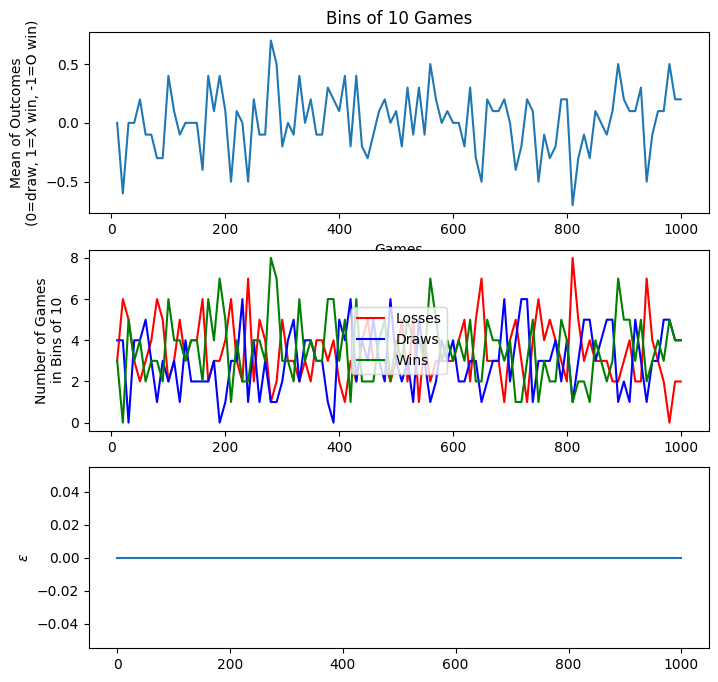

In [ ]:
plt.figure(figsize=(8, 8))
plotOutcomes(outcomes, np.zeros(1000), 1000, 1000)

Finally, let's write the whole Tic-Tac-Toe learning loop!

In [ ]:
from IPython.display import display, clear_output

Outcomes: 8843 X wins 600 O wins 557 draws


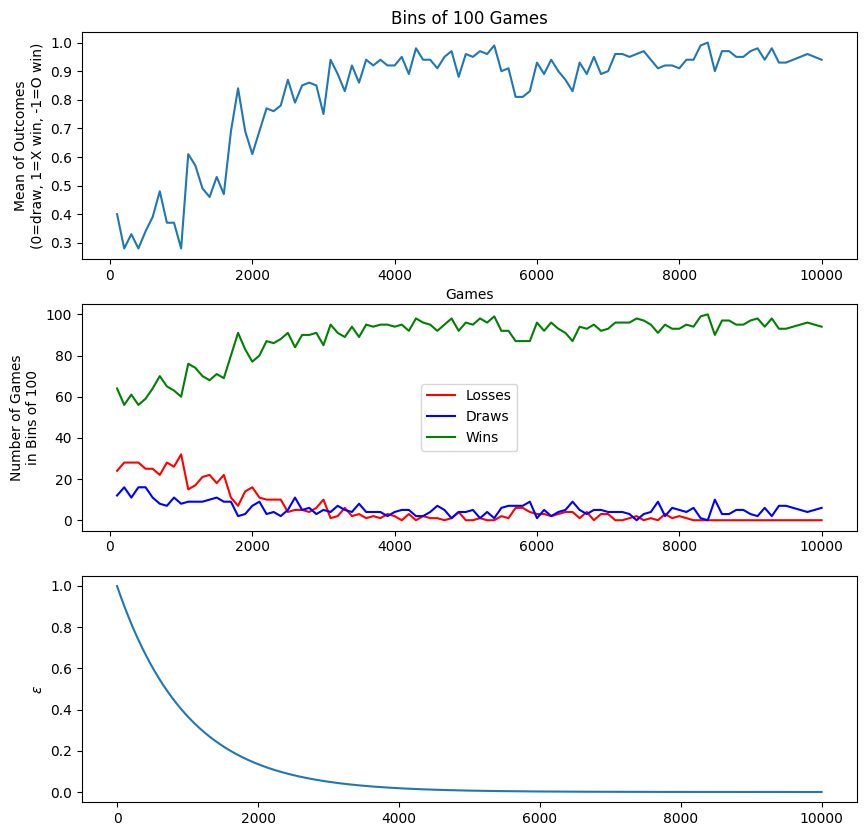

In [ ]:
maxGames = 10000
rho = 0.5
epsilonDecayRate = 0.999
epsilon = 1.0
graphics = True
showMoves = not graphics

outcomes = np.zeros(maxGames)
epsilons = np.zeros(maxGames)
Q = {}

if graphics:
    fig = plt.figure(figsize=(10, 10))

for nGames in range(maxGames):

    epsilon *= epsilonDecayRate
    epsilons[nGames] = epsilon
    step = 0
    board = np.array([' '] * 9)  # empty board
    done = False

    while not done:
        step += 1

        # X's turn
        move = epsilonGreedy(epsilon, Q, board)
        boardNew = copy.copy(board)
        boardNew[move] = 'X'
        if (tuple(board), move) not in Q:
            Q[(tuple(board), move)] = 0  # initial Q value for new board,move
        if showMoves:
            printBoard(boardNew)

        if winner(boardNew):
            # X won!
            if showMoves:
                print('        X Won!')
            Q[(tuple(board), move)] = 1
            done = True
            outcomes[nGames] = 1

        elif not np.any(boardNew == ' '):
            # Game over. No winner.
            if showMoves:
                print('        draw.')
            Q[(tuple(board), move)] = 0
            done = True
            outcomes[nGames] = 0

        else:
            # O's turn.  O is a random player!
            moveO = np.random.choice(np.where(boardNew==' ')[0])
            boardNew[moveO] = 'O'
            if showMoves:
                printBoard(boardNew)
            if winner(boardNew):
                # O won!
                if showMoves:
                    print('        O Won!')
                Q[(tuple(board), move)] += rho * (-1 - Q[(tuple(board), move)])
                done = True
                outcomes[nGames] = -1

        if step > 1:
            Q[(tuple(boardOld), moveOld)] += rho * (Q[(tuple(board), move)] - Q[(tuple(boardOld), moveOld)])

        boardOld, moveOld = board, move # remember board and move to Q(board,move) can be updated after next steps
        board = boardNew

        if graphics and (nGames % (maxGames/10) == 0 or nGames == maxGames-1):
            fig.clf()
            plotOutcomes(outcomes, epsilons ,maxGames, nGames-1)
            clear_output(wait=True)
            display(fig);

if graphics:
    clear_output(wait=True)
print('Outcomes: {:d} X wins {:d} O wins {:d} draws'.format(np.sum(outcomes==1), np.sum(outcomes==-1), np.sum(outcomes==0)))

Now let's examine the Q table after this training, for an empty board and various moves.

In [ ]:
board = np.array([' ']*9)
move = 0
printBoard(board)
print("Q[board,%s] = %s" % (move, Q.get((tuple(board),move))))
board[move] = 'X'
printBoard(board)


 | | 
-----
 | | 
-----
 | | 
Q[board,0] = 0.20906890533260303

X| | 
-----
 | | 
-----
 | | 


In [ ]:
board = np.array([' ']*9)
move = 1
printBoard(board)
print("Q[board,%s] = %s" % (move, Q.get((tuple(board),move))))
board[move] = 'X'
printBoard(board)


 | | 
-----
 | | 
-----
 | | 
Q[board,1] = 0.23660030131536341

 |X| 
-----
 | | 
-----
 | | 


In [ ]:
[Q.get((tuple([' ']*9),m), 0) for m in range(9)] # print the Q values for the empty board for each move

[0.20906890533260303,
 0.23660030131536341,
 0.3473791702428523,
 0.2906945949341493,
 0.327422436467088,
 0.33243607750354465,
 0.9832814045303782,
 0.27418543129475,
 0.22195326455771458]

Let's visualize this a little better.

In [ ]:
board = np.array([' ']*9)
Qs = [Q.get((tuple(board),m), 0) for m in range(9)]
printBoard(board)
print('''{:.2f} | {:.2f} | {:.2f}
------------------
{:.2f} | {:.2f} | {:.2f}
------------------
{:.2f} | {:.2f} | {:.2f}'''.format(*Qs))


 | | 
-----
 | | 
-----
 | | 
0.21 | 0.24 | 0.35
------------------
0.29 | 0.33 | 0.33
------------------
0.98 | 0.27 | 0.22


What's the best move?

In [ ]:
np.argmax(Qs)

6

Worst move?

In [ ]:
np.argmin(Qs)

0

In [ ]:
def printBoardQs(board,Q):
    printBoard(board)
    Qs = [Q.get((tuple(board),m), 0) for m in range(9)]
    print()
    print('''{:.2f} | {:.2f} | {:.2f}
------------------
{:.2f} | {:.2f} | {:.2f}
------------------
{:.2f} | {:.2f} | {:.2f}'''.format(*Qs))

OK, let's play a game!  Player 1 will be X and will choose the move with the highest Q value.  Player 2 will be O and will choose the move with the lowest Q value.

In [ ]:
curQs = [Q.get((tuple(board),m), 0) for m in range(9)]
board[np.argmax([curQs[i] if board[i] == ' ' else -float('inf') for i in range(len(curQs))])] = 'X'
board[np.argmin([curQs[i] if board[i] == ' ' else float('inf') for i in range(len(curQs))])] = 'O'
printBoardQs(board,Q)


O| | 
-----
 | | 
-----
X| | 

0.00 | 0.00 | 0.25
------------------
0.00 | 1.00 | -0.03
------------------
0.00 | 0.00 | 0.25


In [ ]:
curQs = [Q.get((tuple(board),m), 0) for m in range(9)]
board[np.argmax([curQs[i] if board[i] == ' ' else -float('inf') for i in range(len(curQs))])] = 'X'
board[np.argmin([curQs[i] if board[i] == ' ' else float('inf') for i in range(len(curQs))])] = 'O'
printBoardQs(board,Q)


O| | 
-----
 |X|O
-----
X| | 

0.00 | 0.00 | 1.00
------------------
0.00 | 0.00 | 0.00
------------------
0.00 | 0.75 | 0.00


In [ ]:
curQs = [Q.get((tuple(board),m), 0) for m in range(9)]
board[np.argmax([curQs[i] if board[i] == ' ' else -float('inf') for i in range(len(curQs))])] = 'X'
board[np.argmin([curQs[i] if board[i] == ' ' else float('inf') for i in range(len(curQs))])] = 'O'
printBoardQs(board,Q)


O|O|X
-----
 |X|O
-----
X| | 

0.00 | 0.00 | 0.00
------------------
0.00 | 0.00 | 0.00
------------------
0.00 | 0.00 | 0.00


X wins! This should not be surprising.

Let's try again and maybe let O be a little smarter :-)

In [ ]:
board = np.array([' ']*9) # reset the board
curQs = [Q.get((tuple(board),m), 0) for m in range(9)]
printBoardQs(board,Q)


 | | 
-----
 | | 
-----
 | | 

0.21 | 0.24 | 0.35
------------------
0.29 | 0.33 | 0.33
------------------
0.98 | 0.27 | 0.22


In [ ]:
curQs = [Q.get((tuple(board),m), 0) for m in range(9)]
board[np.argmax([curQs[i] if board[i] == ' ' else -float('inf') for i in range(len(curQs))])] = 'X'
board[np.argmax([curQs[i] if board[i] == ' ' else -float('inf') for i in range(len(curQs))])] = 'O'
printBoardQs(board,Q)


 | |O
-----
 | | 
-----
X| | 

1.00 | 0.00 | 0.00
------------------
0.21 | -0.25 | 0.06
------------------
0.00 | 0.00 | 0.00


In [ ]:
curQs = [Q.get((tuple(board),m), 0) for m in range(9)]
board[np.argmax([curQs[i] if board[i] == ' ' else -float('inf') for i in range(len(curQs))])] = 'X'
board[np.argmax([curQs[i] if board[i] == ' ' else -float('inf') for i in range(len(curQs))])] = 'O'
printBoardQs(board,Q)


X| |O
-----
O| | 
-----
X| | 

0.00 | 0.00 | 0.00
------------------
0.00 | 1.00 | 0.00
------------------
0.00 | 0.00 | 0.00


In [ ]:
curQs = [Q.get((tuple(board),m), 0) for m in range(9)]
board[np.argmax([curQs[i] if board[i] == ' ' else -float('inf') for i in range(len(curQs))])] = 'X'
board[np.argmax([curQs[i] if board[i] == ' ' else -float('inf') for i in range(len(curQs))])] = 'O'
printBoardQs(board,Q)


X|O|O
-----
O|X| 
-----
X| | 

0.00 | 0.00 | 0.00
------------------
0.00 | 0.00 | 0.00
------------------
0.00 | 0.00 | 1.00


X will still win, but O made it (kinda) competitive.  What was O's strategy here?

```
np.argsort([curQs[i] if board[i] == ' ' else -float('inf') for i in range(len(curQs))])[-2]
```

OK, let's try one more where I will deliberately choose the moves instead of relying on the Q values.  And we'll examine the resulting Q values.

In [ ]:
board = np.array([' ']*9) # reset the board
printBoardQs(board,Q)


 | | 
-----
 | | 
-----
 | | 

0.21 | 0.24 | 0.35
------------------
0.29 | 0.33 | 0.33
------------------
0.98 | 0.27 | 0.22


In [ ]:
board[6] = 'X'
board[2] = 'O'
printBoardQs(board,Q)


 | |O
-----
 | | 
-----
X| | 

1.00 | 0.00 | 0.00
------------------
0.21 | -0.25 | 0.06
------------------
0.00 | 0.00 | 0.00


In [ ]:
board[8] = 'X'
board[3] = 'O'
printBoardQs(board,Q)


 | |O
-----
O| | 
-----
X| |X

1.00 | 0.00 | 0.00
------------------
0.00 | 0.00 | 0.00
------------------
0.00 | 0.00 | 0.00


Now there's an obvious path for X to win.  But what if X made a mistake instead?  Let's undo these moves and make some others.

In [ ]:
board[8] = ' '
board[3] = ' '
board[4] = 'X'
board[0] = 'O'
printBoardQs(board,Q)


O| |O
-----
 |X| 
-----
X| | 

0.00 | 1.00 | 0.00
------------------
0.00 | 0.00 | -0.25
------------------
0.00 | 0.38 | -0.50


Now it's pretty obvious.  Even with optimal moves, the game should end in a draw.

In [ ]:
board[1] = 'X'
board[7] = 'O'
printBoardQs(board,Q)


O|X|O
-----
 |X| 
-----
X|O| 

0.00 | 0.00 | 0.00
------------------
0.50 | 0.00 | 0.00
------------------
0.00 | 0.00 | 0.00


In [ ]:
board[3] = 'X'
board[5] = 'O'
printBoardQs(board,Q)


O|X|O
-----
X|X|O
-----
X|O| 

0.00 | 0.00 | 0.00
------------------
0.00 | 0.00 | 0.00
------------------
0.00 | 0.00 | 0.00


The game is over.  No future moves lead to a victory.

# Neural Network as Q function for Tic-Tac-Toe

In [ ]:
import neuralnetworks_A5 as nn

To use a neural network, we must represent the board numerically.  Let's use a vector of 9 values of either 1, -1, or 0 to represent 'X', 'O', or no markers.

And, let's use one Qnet for Player X and a different one for Player O!

In [ ]:
def initial_state():
    return np.array([0] * 9)

def next_state(s, a, marker):  # s is a board, and a is an index into the cells of the board, marker is 1 or -1
    s = s.copy()
    s[a] = 1 if marker == 'X' else -1
    return s

def reinforcement(s):
    if won('X', s):
        return 1
    if won('O', s):
        return -1
    return 0

def won(player, s):
    marker = 1 if player == 'X' else -1
    combos = np.array((0,1,2, 3,4,5, 6,7,8, 0,3,6, 1,4,7, 2,5,8, 0,4,8, 2,4,6))
    return np.any(np.all(marker == s[combos].reshape((-1, 3)), axis=1))

def draw(s):
    return sum(s == 0) == 0

In [ ]:
def valid_actions(state):
    return np.where(state == 0)[0]

In [ ]:
def stack_sa(s, a):
    return np.hstack((s, a)).reshape(1, -1)

def other_player(player):
    return 'X' if player == 'O' else 'O'

In [ ]:
def epsilon_greedy(Qnet, player, state, epsilon):

    actions = valid_actions(state)

    if np.random.uniform() < epsilon:
        # Random Move
        action = np.random.choice(actions)

    else:
        # Greedy Move
        np.random.shuffle(actions)
        Qs = np.array([Qnet.use(stack_sa(state, a)) for a in actions])

        if player == 'X':
            action = actions[np.argmax(Qs)]
        elif player == 'O':
            action = actions[np.argmin(Qs)]

    return action

In [ ]:
def make_samples(Qnets, initial_state_f, next_state_f, reinforcement_f, epsilon):
    '''Run one game'''
    X = []
    R = []
    Qn = []

    s = initial_state_f()
    player = 'X'

    while True:

        a = epsilon_greedy(Qnets[player], player, s, epsilon)
        sn = next_state_f(s, a, player)
        r = reinforcement_f(s)

        X.append(stack_sa(s, a))
        R.append(r)

        if r != 0 or draw(sn):
            break

        s = sn
        player = other_player(player)  # switch

    X = np.vstack(X)
    R = np.array(R).reshape(-1, 1)

    # Assign all Qn's, based on following state, but go every other state to do all X values,
    # and to do all O values.
    Qn = np.zeros_like(R)
    if len(Qn) % 2 == 1:
        # Odd number of samples, so 0 won
        # for X samples
        Qn[:-4:2, :] = Qnets['X'].use(X[2:-2:2])  # leave last sample Qn=0
        R[-2, 0] = R[-1, 0]  # copy final r (win for O) to last X state, too
        # for O samples
        Qn[1:-4:2, :] = Qnets['O'].use(X[3:-2:2])  # leave last sample Qn=0
    else:
        # Odd number of samples, so X won or draw
        # for X samples
        Qn[:-4:2, :] = Qnets['X'].use(X[2:-2:2])  # leave last sample Qn=0
        R[-2, 0] = - R[-1, 0]  # copy negated final r (win for X) to last O state, too
        # for O samples
        Qn[1:-4:2, :] = Qnets['O'].use(X[3:-2:2])

    return {'X': X, 'R': R, 'Qn': Qn}

In [ ]:
def plot_status(outcomes, epsilons, n_trials, trial):
    if trial == 0:
        return
    outcomes = np.array(outcomes)
    n_per = 10
    n_bins = (trial + 1) // n_per
    if n_bins == 0:
        return
    outcome_rows = outcomes[:n_per * n_bins].reshape((-1, n_per))
    outcome_rows = outcome_rows[:trial // n_per + 1, :]
    avgs = np.mean(outcome_rows, axis=1)

    plt.subplot(3, 1, 1)
    xs = np.linspace(n_per, n_per * n_bins, len(avgs))
    plt.plot(xs, avgs)
    plt.ylim(-1.1, 1.1)
    plt.xlabel('Games')
    plt.ylabel('Mean of Outcomes') # \n(0=draw, 1=X win, -1=O win)')
    plt.title(f'Bins of {n_per:d} Games')

    plt.subplot(3, 1, 2)
    plt.plot(xs, np.sum(outcome_rows == -1, axis=1), 'r-', label='Losses')
    plt.plot(xs, np.sum(outcome_rows == 0, axis=1), 'b-', label='Draws')
    plt.plot(xs, np.sum(outcome_rows == 1, axis=1), 'g-', label='Wins')
    plt.legend(loc='center')
    plt.ylabel(f'Number of Games\nin Bins of {n_per:d}')

    plt.subplot(3, 1, 3)
    plt.plot(epsilons[:trial])
    plt.ylabel('$\epsilon$')


In [ ]:
def setup_standardization(Qnet, Xmeans, Xstds, Tmeans, Tstds):
    Qnet.Xmeans = np.array(Xmeans)
    Qnet.Xstds = np.array(Xstds)
    Qnet.Tmeans = np.array(Tmeans)
    Qnet.Tstds = np.array(Tstds)

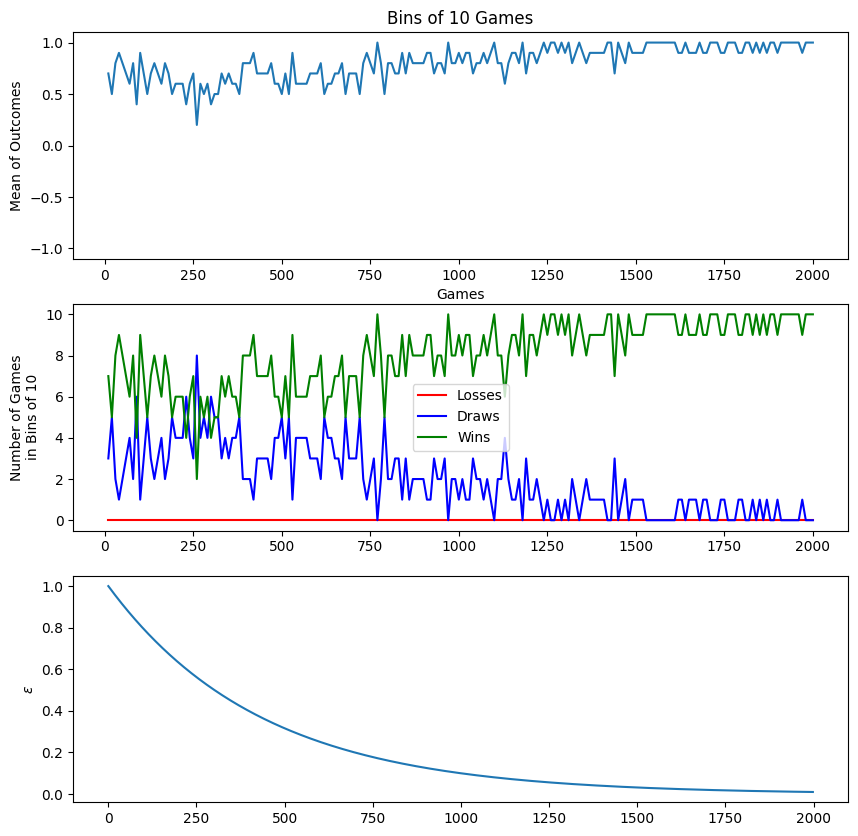

In [ ]:
from IPython.display import display, clear_output
fig = plt.figure(figsize=(10, 10))

gamma = 0.8       # discount factor
n_trials = 2000         # number of repetitions of makeSamples-updateQ loop
n_epochs = 5
learning_rate = 0.01
final_epsilon = 0.01 # value of epsilon at end of simulation. Decay rate is calculated
epsilon_decay =  np.exp(np.log(final_epsilon) / (n_trials)) # to produce this final value
# epsilon_decay = 1  # to force both players to take random actions
print('epsilon_decay is', epsilon_decay)

#################################################################################
# Qnet for Player 'X'
nhX = [5]  # hidden layers structure
QnetX = nn.NeuralNetwork(9 + 1, nhX, 1)

# Qnet for Player 'O'
nhO = [10,100,2]  # hidden layers structure -- try [10,100,2]
QnetO = nn.NeuralNetwork(9 + 1, nhO, 1)
#################################################################################

# Inputs are 9 TTT cells plus 1 action
setup_standardization(QnetX, [0] * 10, [1] * 10, [0], [1])
setup_standardization(QnetO, [0] * 10, [1] * 10, [0], [1])

Qnets = {'X': QnetX, 'O': QnetO}

fig = plt.figure(1, figsize=(10, 10))

epsilon = 1         # initial epsilon value
outcomes = []
epsilon_trace = []

# Train for n_trials
for trial in range(n_trials):

    samples = make_samples(Qnets, initial_state, next_state, reinforcement, epsilon)

    for player in ['X', 'O']:
        first_sample = 0 if player == 'X' else 1
        rows = slice(0, None, 2) if player == 'X' else slice(1, None, 2)
        X = samples['X'][rows, :]
        R = samples['R'][rows, :]
        Qn = samples['Qn'][rows, :]
        T = R + gamma * Qn
        Qnets[player].train(X, T, n_epochs, learning_rate, method='sgd', verbose=False)

    # Rest is for plotting
    epsilon_trace.append(epsilon)
    epsilon *= epsilon_decay
    n_moves = len(samples['R'])
    final_r = samples['R'][-1]
    # if odd n_moves, then O won so negate final_r for X perspective
    outcome = final_r if n_moves % 2 == 0 else -final_r
    outcomes.append(outcome)
    if True and (trial + 1 == n_trials or trial % (n_trials / 20) == 0):
        fig.clf()
        plot_status(outcomes, epsilon_trace, n_trials, trial)
        clear_output(wait=True)
        display(fig)

clear_output(wait=True);

Let's play!

First create versions of `printBoard` and `printBoardQs` that'll work with our new representation.

In [ ]:
def printBoard(board):
    board_arr = np.where(board == 0, ' ', board)
    board_arr = np.where(board == 1, 'X', board_arr)
    board_arr = np.where(board == -1, 'O', board_arr)
    print('''
{}|{}|{}
-----
{}|{}|{}
-----
{}|{}|{}'''.format(*tuple(board_arr)))

In [ ]:
def printBoardQs(Qs):
    print()
    print('''{:.2f} | {:.2f} | {:.2f}
------------------
{:.2f} | {:.2f} | {:.2f}
------------------
{:.2f} | {:.2f} | {:.2f}'''.format(*[q[0][0] for q in Qs]))

In [ ]:
board = np.array([0]*9) # reset the board
curQXs = [QnetX.use(stack_sa(tuple(board),m)) for m in range(9)]
curQOs = [QnetO.use(stack_sa(tuple(board),m)) for m in range(9)]
print("Board:")
printBoard(board)
print("\nX Qs:")
printBoardQs(curQXs)
print("\nO Qs:")
printBoardQs(curQOs)

Board:

 | | 
-----
 | | 
-----
 | | 

X Qs:

-0.50 | -0.40 | -0.27
------------------
-0.16 | -0.09 | -0.05
------------------
-0.02 | -0.01 | -0.00

O Qs:

0.44 | 0.27 | 0.17
------------------
0.12 | 0.10 | 0.08
------------------
0.07 | 0.07 | 0.06


There's no knowledge of the rules (e.g., X goes first).

In [ ]:
board[epsilon_greedy(Qnets['X'], 'X', board, 0.01)] = 1 # move X
print("\nBoard:")
printBoard(board)
if won('X',board):
    print("\X wins!")
else:
    print()
    curQOs = [QnetO.use(stack_sa(tuple(board),m)) for m in range(9)]
    print("O Qs after X's move:")
    printBoardQs(curQOs)
    board[epsilon_greedy(Qnets['O'], 'O', board, 0.01)] = -1 # move O
    print("\nBoard:")
    printBoard(board)
    if won('O',board):
        print("O wins!")
    else:
        curQXs = [QnetX.use(stack_sa(tuple(board),m)) for m in range(9)]
        print("\nX Qs after O's move:")
        printBoardQs(curQXs)


Board:

 | |X
-----
O|X|O
-----
X|O|X
X wins!
